In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# Point generation with noise
def gen_data(num_samples, noise=0):
    points = []
    labels = []

    for i in range(num_samples):
        x = np.random.uniform()
        y = np.random.uniform()

        nx = np.random.uniform(low=-noise/100, high=noise/100)
        ny = np.random.uniform(low=-noise/100, high=noise/100)

        if(-0.7*x-y+0.6 < 0 and -0.8*x-y+1.1 > 0 and 2.5*x-y > 0 and 5*x-y-3 < 0):
            if noise > 0:
                points.append([x+nx, y+ny, 0])
                labels.append(0)
            else:
                points.append([x, y, 0])
                labels.append(0)
        else:
            if noise > 0:
                points.append([x+nx, y+ny, 1])
                labels.append(1)
            else:
                points.append([x, y, 1])
                labels.append(1)

    return points, labels

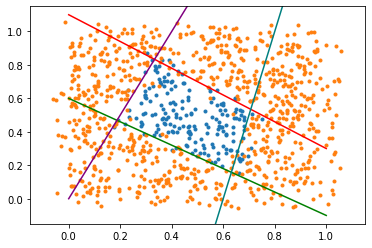

In [3]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, -(0.7*x-0.6), 'green')  # y = -0.7*x+0.6 => -0.7*x-y+0.6 >0
plt.plot(x, -(0.8*x-1.1), 'red')    # y = -0.8*x+1.1 => -0.8*x-y+1.1 < 0 
plt.plot(x, (2.5*x), 'purple')      # y = 2.5*x => 2.5*x-y < 0
plt.plot(x, (5*x-3), 'teal')        # y = 5*x-3 => 5*x-y-3 > 0

plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [4]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [5]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta 1:", self.beta.data.item())
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )
    

In [6]:
# implement class wrapper for swish activation function
class Swish(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super(Swish, self).__init__()

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        return x * torch.sigmoid(x)

In [7]:
class Net4(nn.Module):
    def __init__(self, activation = 'squashing'):
        super(Net4,self).__init__()

        self.g1_layer = nn.Linear(in_features=2, out_features=1)
        self.g2_layer = nn.Linear(in_features=2, out_features=1)
        self.g3_layer = nn.Linear(in_features=2, out_features=1)
        self.g4_layer = nn.Linear(in_features=2, out_features=1)

        self.undgout = nn.Linear(in_features=4, out_features=1)
        
        self.undgout.bias.requires_grad  = False
        self.undgout.weight.requires_grad = False
  
        with torch.no_grad():
            self.undgout.bias.fill_(-3.0)
            self.undgout.weight.fill_(1.0)
        
        if activation == 'relu':
            print("relu")
            self.activation_g1 = nn.ReLU()
            self.activation_g2 = nn.ReLU()
            self.activation_g3 = nn.ReLU()
            self.activation_g4 = nn.ReLU()
            self.activation_and = nn.ReLU()
            
        if activation == 'sigmoid':
            print("sigmoid")
            self.activation_g1 = nn.Sigmoid()
            self.activation_g2 = nn.Sigmoid()
            self.activation_g3 = nn.Sigmoid()
            self.activation_g4 = nn.Sigmoid()
            self.activation_and = nn.Sigmoid()
            
        if activation == 'swish':
            print("swish")
            self.activation = Swish()
            self.activation1 = Swish()

        if activation == "tanh":
            print("tanh")
            self.activation_g1 = nn.Tanh()
            self.activation_g2 = nn.Tanh()
            self.activation_g3 = nn.Tanh()
            self.activation_g4 = nn.Tanh()
            self.activation_and = nn.Tanh()
            
        if activation == 'squashing':
            print("squashing")
            self.activation_g1 = Squashing()
            self.activation_g2 = Squashing()
            self.activation_g3 = Squashing()
            self.activation_g4 = Squashing()
            self.activation_and = Squashing()
            
        if (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = Squashing(False, beta=1)
            self.activation1 = Squashing(False, beta=-1)
        
        
    #This must be implemented
    def forward(self, x):
        global beta_and
        global beta_g1
        global beta_g2
        global beta_g3
        global beta_g4
        
        g1 = self.g1_layer(x)
        g1 = self.activation_g1(g1)
        #beta_g1 = betas

        g2 = self.g2_layer(x)
        g2 = self.activation_g2(g2)
        #beta_g2 = betas
        
        g3 = self.g3_layer(x)
        g3 = self.activation_g3(g3)
        #beta_g3 = betas

        g4 = self.g4_layer(x)
        g4 = self.activation_g4(g4)
        #beta_g4 = betas

        z = self.undgout(torch.cat((g1,g2,g3,g4), 1))
        z = self.activation_and(z)
        #beta_and = betas

        return z


sigmoid
Epoch: 0
G1-Weight: tensor([[-0.1677,  0.6715]]) G1-Bias: tensor([-0.4267])
G2-Weight: tensor([[-0.4810, -0.2143]]) G2-Bias: tensor([0.1333])
G3-Weight: tensor([[ 0.1690, -0.3216]]) G1-Bias: tensor([0.3280])
G4-Weight: tensor([[0.3994, 0.3054]]) G2-Bias: tensor([0.1733])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.1677 * x + -0.4267) / 0.6715)
z2: y = -((-0.481 * x + 0.1333) / -0.2143)
z3: y = -((0.169 * x + 0.328) / -0.3216)
z4: y = -((0.3994 * x + 0.1733) / 0.3054)


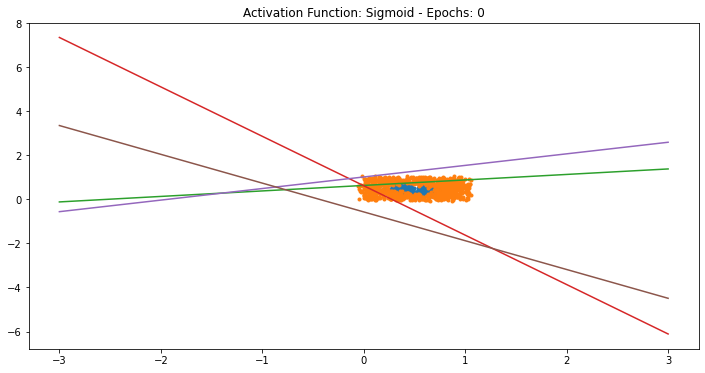

Epoch: 100
G1-Weight: tensor([[1.0984, 1.8610]]) G1-Bias: tensor([0.9636])
G2-Weight: tensor([[0.7933, 1.0331]]) G2-Bias: tensor([1.4969])
G3-Weight: tensor([[1.3071, 0.8546]]) G1-Bias: tensor([1.6111])
G4-Weight: tensor([[1.5062, 1.4199]]) G2-Bias: tensor([1.4442])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.0984 * x + 0.9636) / 1.861)
z2: y = -((0.7933 * x + 1.4969) / 1.0331)
z3: y = -((1.3071 * x + 1.6111) / 0.8546)
z4: y = -((1.5062 * x + 1.4442) / 1.4199)


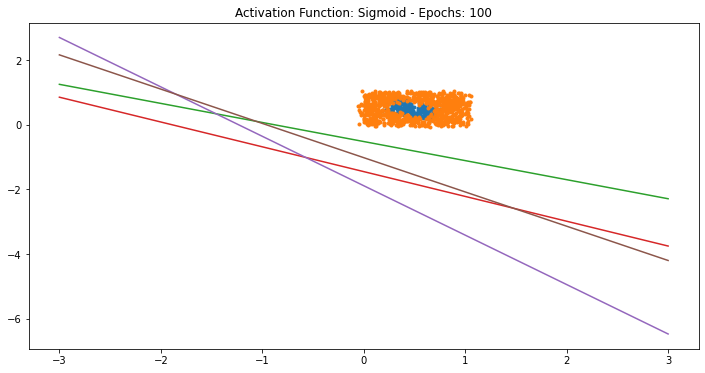

Epoch: 200
G1-Weight: tensor([[1.4103, 2.1135]]) G1-Bias: tensor([1.4617])
G2-Weight: tensor([[1.0880, 1.3140]]) G2-Bias: tensor([1.9338])
G3-Weight: tensor([[1.5445, 1.1344]]) G1-Bias: tensor([2.0292])
G4-Weight: tensor([[1.7453, 1.6742]]) G2-Bias: tensor([1.8812])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.4103 * x + 1.4617) / 2.1135)
z2: y = -((1.088 * x + 1.9338) / 1.314)
z3: y = -((1.5445 * x + 2.0292) / 1.1344)
z4: y = -((1.7453 * x + 1.8812) / 1.6742)


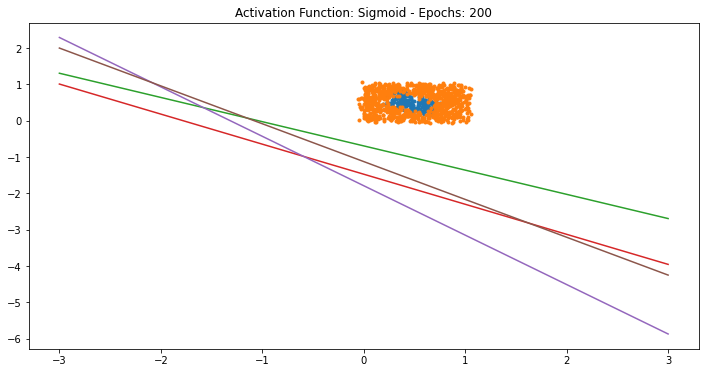

Epoch: 300
G1-Weight: tensor([[1.5960, 2.2613]]) G1-Bias: tensor([1.8059])
G2-Weight: tensor([[1.2617, 1.4806]]) G2-Bias: tensor([2.2314])
G3-Weight: tensor([[1.6862, 1.3089]]) G1-Bias: tensor([2.3211])
G4-Weight: tensor([[1.8911, 1.8330]]) G2-Bias: tensor([2.1900])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.596 * x + 1.8059) / 2.2613)
z2: y = -((1.2617 * x + 2.2314) / 1.4806)
z3: y = -((1.6862 * x + 2.3211) / 1.3089)
z4: y = -((1.8911 * x + 2.19) / 1.833)


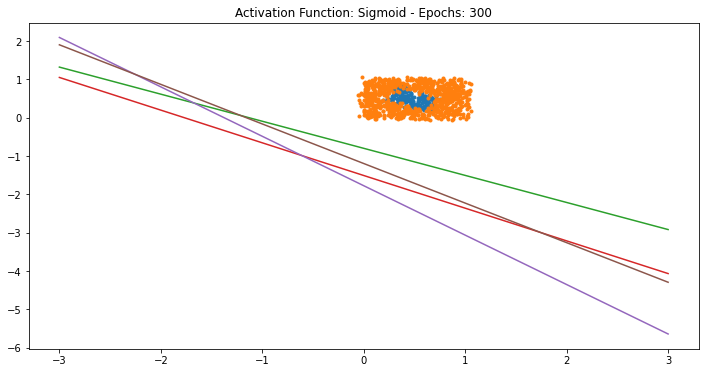

Epoch: 400
G1-Weight: tensor([[1.7299, 2.3679]]) G1-Bias: tensor([2.0763])
G2-Weight: tensor([[1.3869, 1.6016]]) G2-Bias: tensor([2.4663])
G3-Weight: tensor([[1.7893, 1.4383]]) G1-Bias: tensor([2.5538])
G4-Weight: tensor([[1.9983, 1.9510]]) G2-Bias: tensor([2.4364])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.7299 * x + 2.0763) / 2.3679)
z2: y = -((1.3869 * x + 2.4663) / 1.6016)
z3: y = -((1.7893 * x + 2.5538) / 1.4383)
z4: y = -((1.9983 * x + 2.4364) / 1.951)


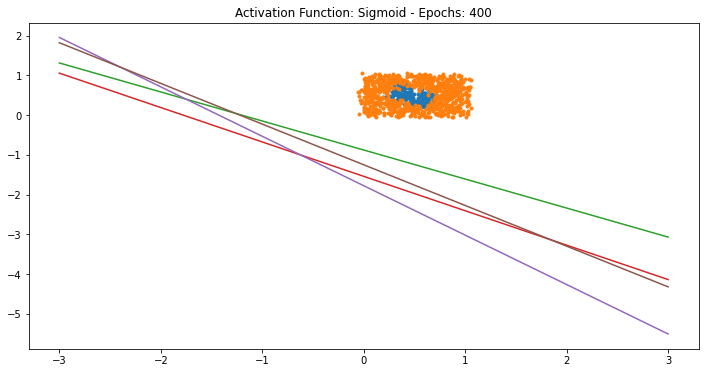

Epoch: 500
G1-Weight: tensor([[1.8351, 2.4522]]) G1-Bias: tensor([2.3018])
G2-Weight: tensor([[1.4857, 1.6975]]) G2-Bias: tensor([2.6638])
G3-Weight: tensor([[1.8711, 1.5419]]) G1-Bias: tensor([2.7504])
G4-Weight: tensor([[2.0840, 2.0457]]) G2-Bias: tensor([2.6444])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.8351 * x + 2.3018) / 2.4522)
z2: y = -((1.4857 * x + 2.6638) / 1.6975)
z3: y = -((1.8711 * x + 2.7504) / 1.5419)
z4: y = -((2.084 * x + 2.6444) / 2.0457)


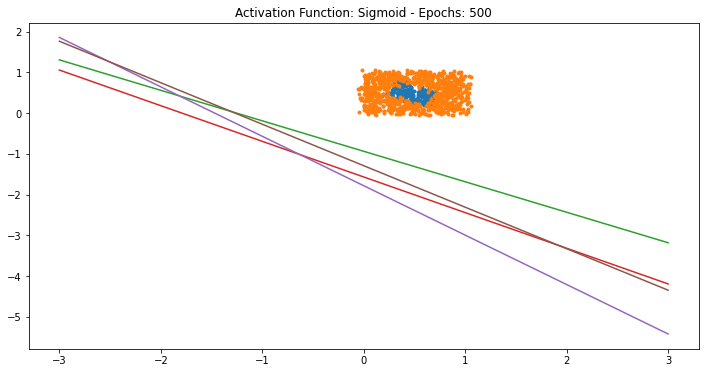

Epoch: 600
G1-Weight: tensor([[1.9221, 2.5225]]) G1-Bias: tensor([2.4966])
G2-Weight: tensor([[1.5677, 1.7774]]) G2-Bias: tensor([2.8362])
G3-Weight: tensor([[1.9395, 1.6288]]) G1-Bias: tensor([2.9224])
G4-Weight: tensor([[2.1559, 2.1254]]) G2-Bias: tensor([2.8258])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.9221 * x + 2.4966) / 2.5225)
z2: y = -((1.5677 * x + 2.8362) / 1.7774)
z3: y = -((1.9395 * x + 2.9224) / 1.6288)
z4: y = -((2.1559 * x + 2.8258) / 2.1254)


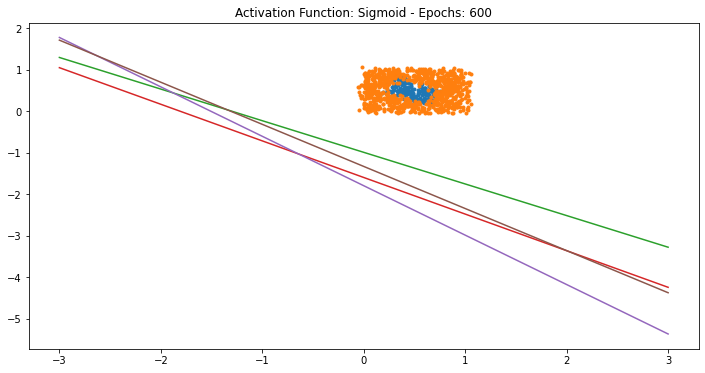

Epoch: 700
G1-Weight: tensor([[1.9967, 2.5830]]) G1-Bias: tensor([2.6691])
G2-Weight: tensor([[1.6380, 1.8462]]) G2-Bias: tensor([2.9902])
G3-Weight: tensor([[1.9987, 1.7040]]) G1-Bias: tensor([3.0763])
G4-Weight: tensor([[2.2182, 2.1945]]) G2-Bias: tensor([2.9877])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.9967 * x + 2.6691) / 2.583)
z2: y = -((1.638 * x + 2.9902) / 1.8462)
z3: y = -((1.9987 * x + 3.0763) / 1.704)
z4: y = -((2.2182 * x + 2.9877) / 2.1945)


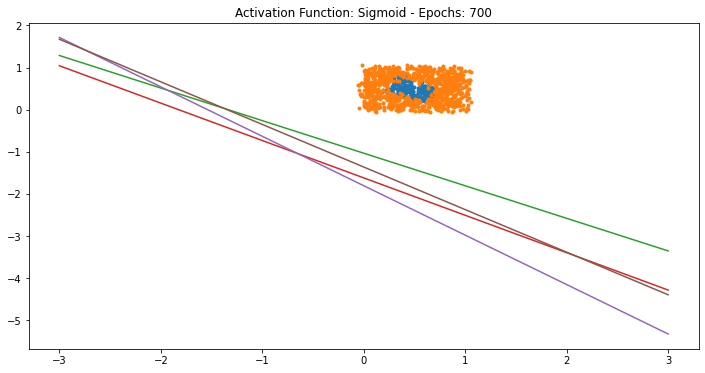

Epoch: 800
G1-Weight: tensor([[2.0620, 2.6365]]) G1-Bias: tensor([2.8245])
G2-Weight: tensor([[1.6999, 1.9069]]) G2-Bias: tensor([3.1301])
G3-Weight: tensor([[2.0509, 1.7703]]) G1-Bias: tensor([3.2163])
G4-Weight: tensor([[2.2734, 2.2556]]) G2-Bias: tensor([3.1345])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.062 * x + 2.8245) / 2.6365)
z2: y = -((1.6999 * x + 3.1301) / 1.9069)
z3: y = -((2.0509 * x + 3.2163) / 1.7703)
z4: y = -((2.2734 * x + 3.1345) / 2.2556)


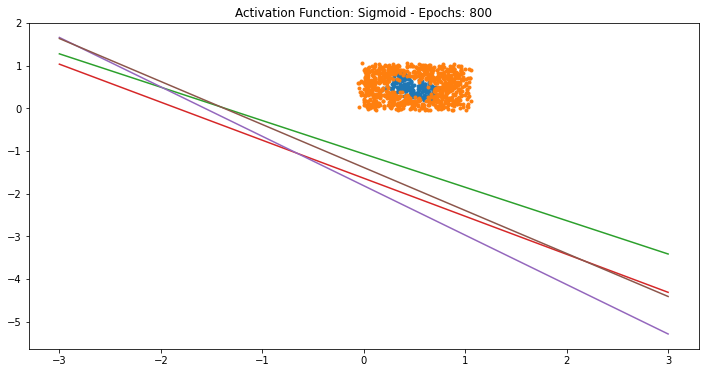

Epoch: 900
G1-Weight: tensor([[2.1203, 2.6846]]) G1-Bias: tensor([2.9664])
G2-Weight: tensor([[1.7552, 1.9613]]) G2-Bias: tensor([3.2588])
G3-Weight: tensor([[2.0980, 1.8298]]) G1-Bias: tensor([3.3452])
G4-Weight: tensor([[2.3232, 2.3107]]) G2-Bias: tensor([3.2692])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.1203 * x + 2.9664) / 2.6846)
z2: y = -((1.7552 * x + 3.2588) / 1.9613)
z3: y = -((2.098 * x + 3.3452) / 1.8298)
z4: y = -((2.3232 * x + 3.2692) / 2.3107)


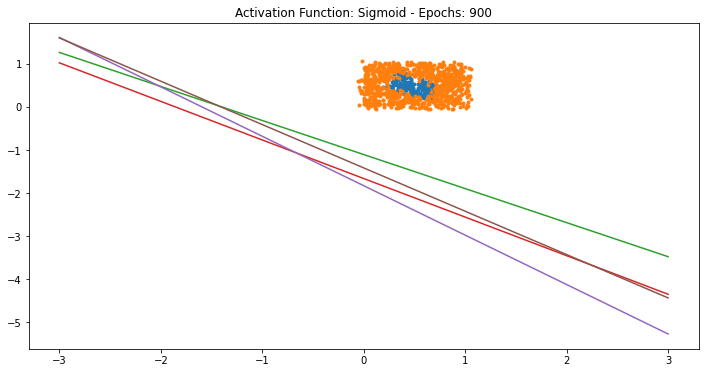

Epoch: 1000
G1-Weight: tensor([[2.1731, 2.7284]]) G1-Bias: tensor([3.0974])
G2-Weight: tensor([[1.8053, 2.0108]]) G2-Bias: tensor([3.3784])
G3-Weight: tensor([[2.1409, 1.8840]]) G1-Bias: tensor([3.4649])
G4-Weight: tensor([[2.3686, 2.3609]]) G2-Bias: tensor([3.3942])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.1731 * x + 3.0974) / 2.7284)
z2: y = -((1.8053 * x + 3.3784) / 2.0108)
z3: y = -((2.1409 * x + 3.4649) / 1.884)
z4: y = -((2.3686 * x + 3.3942) / 2.3609)


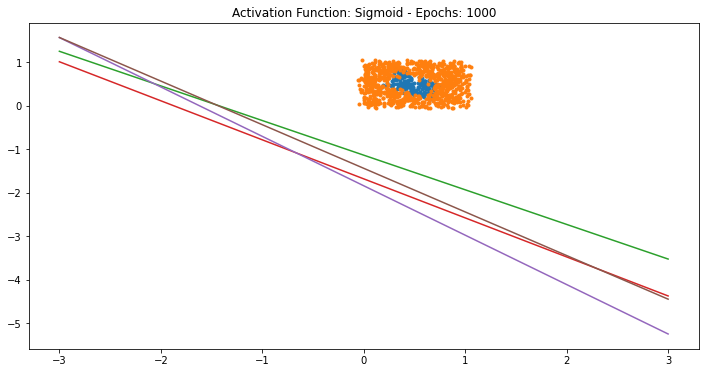

Epoch: 1100
G1-Weight: tensor([[2.2214, 2.7688]]) G1-Bias: tensor([3.2193])
G2-Weight: tensor([[1.8513, 2.0562]]) G2-Bias: tensor([3.4904])
G3-Weight: tensor([[2.1804, 1.9337]]) G1-Bias: tensor([3.5771])
G4-Weight: tensor([[2.4105, 2.4071]]) G2-Bias: tensor([3.5109])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.2214 * x + 3.2193) / 2.7688)
z2: y = -((1.8513 * x + 3.4904) / 2.0562)
z3: y = -((2.1804 * x + 3.5771) / 1.9337)
z4: y = -((2.4105 * x + 3.5109) / 2.4071)


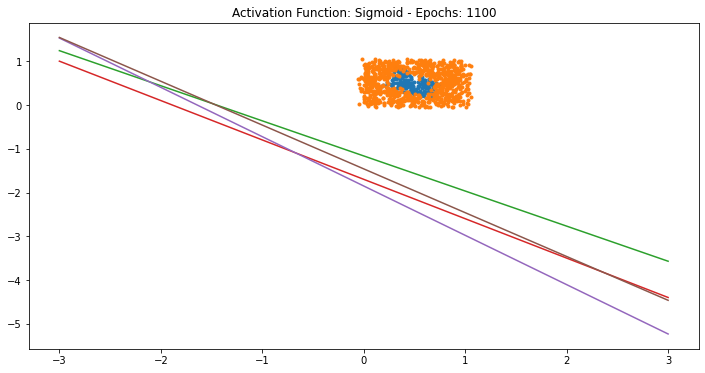

Epoch: 1200
G1-Weight: tensor([[2.2660, 2.8063]]) G1-Bias: tensor([3.3335])
G2-Weight: tensor([[1.8938, 2.0983]]) G2-Bias: tensor([3.5959])
G3-Weight: tensor([[2.2171, 1.9797]]) G1-Bias: tensor([3.6828])
G4-Weight: tensor([[2.4494, 2.4501]]) G2-Bias: tensor([3.6207])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.266 * x + 3.3335) / 2.8063)
z2: y = -((1.8938 * x + 3.5959) / 2.0983)
z3: y = -((2.2171 * x + 3.6828) / 1.9797)
z4: y = -((2.4494 * x + 3.6207) / 2.4501)


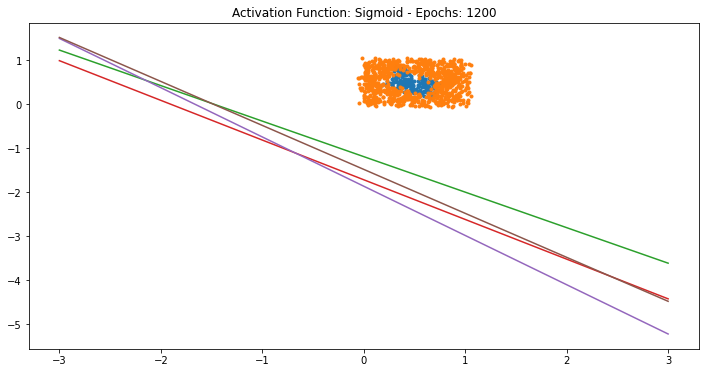

Epoch: 1300
G1-Weight: tensor([[2.3076, 2.8413]]) G1-Bias: tensor([3.4412])
G2-Weight: tensor([[1.9335, 2.1377]]) G2-Bias: tensor([3.6959])
G3-Weight: tensor([[2.2515, 2.0226]]) G1-Bias: tensor([3.7831])
G4-Weight: tensor([[2.4859, 2.4902]]) G2-Bias: tensor([3.7246])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.3076 * x + 3.4412) / 2.8413)
z2: y = -((1.9335 * x + 3.6959) / 2.1377)
z3: y = -((2.2515 * x + 3.7831) / 2.0226)
z4: y = -((2.4859 * x + 3.7246) / 2.4902)


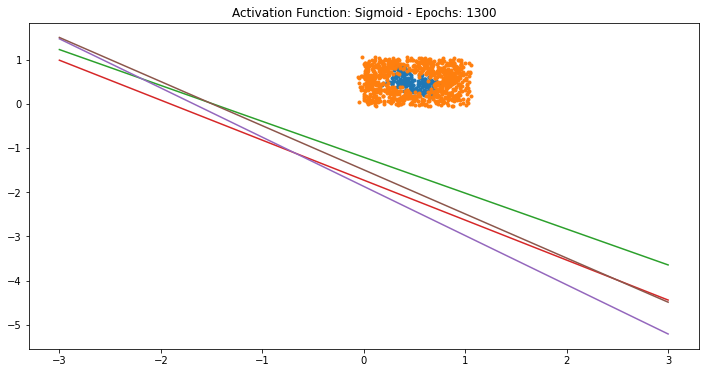

Epoch: 1400
G1-Weight: tensor([[2.3465, 2.8744]]) G1-Bias: tensor([3.5433])
G2-Weight: tensor([[1.9707, 2.1746]]) G2-Bias: tensor([3.7911])
G3-Weight: tensor([[2.2840, 2.0629]]) G1-Bias: tensor([3.8785])
G4-Weight: tensor([[2.5203, 2.5280]]) G2-Bias: tensor([3.8233])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.3465 * x + 3.5433) / 2.8744)
z2: y = -((1.9707 * x + 3.7911) / 2.1746)
z3: y = -((2.284 * x + 3.8785) / 2.0629)
z4: y = -((2.5203 * x + 3.8233) / 2.528)


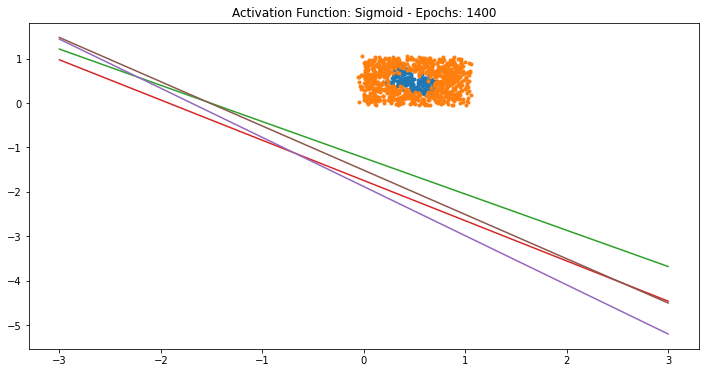

Epoch: 1500
G1-Weight: tensor([[2.3832, 2.9057]]) G1-Bias: tensor([3.6405])
G2-Weight: tensor([[2.0057, 2.2095]]) G2-Bias: tensor([3.8821])
G3-Weight: tensor([[2.3147, 2.1009]]) G1-Bias: tensor([3.9697])
G4-Weight: tensor([[2.5528, 2.5637]]) G2-Bias: tensor([3.9175])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.3832 * x + 3.6405) / 2.9057)
z2: y = -((2.0057 * x + 3.8821) / 2.2095)
z3: y = -((2.3147 * x + 3.9697) / 2.1009)
z4: y = -((2.5528 * x + 3.9175) / 2.5637)


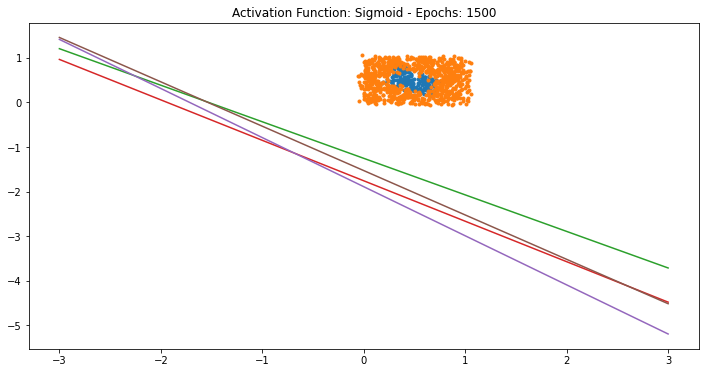

Epoch: 1600
G1-Weight: tensor([[2.4179, 2.9354]]) G1-Bias: tensor([3.7335])
G2-Weight: tensor([[2.0389, 2.2425]]) G2-Bias: tensor([3.9694])
G3-Weight: tensor([[2.3439, 2.1369]]) G1-Bias: tensor([4.0572])
G4-Weight: tensor([[2.5838, 2.5976]]) G2-Bias: tensor([4.0077])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.4179 * x + 3.7335) / 2.9354)
z2: y = -((2.0389 * x + 3.9694) / 2.2425)
z3: y = -((2.3439 * x + 4.0572) / 2.1369)
z4: y = -((2.5838 * x + 4.0077) / 2.5976)


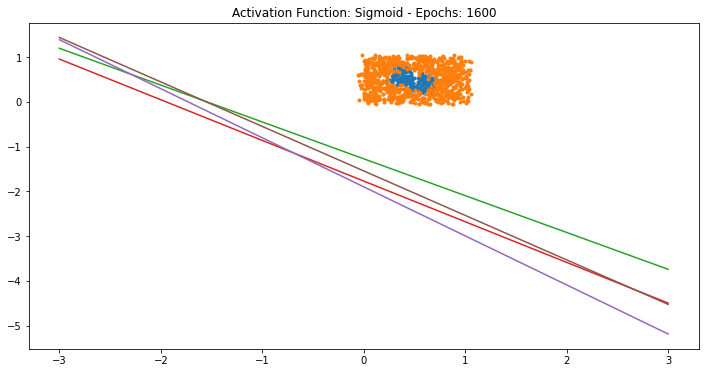

Epoch: 1700
G1-Weight: tensor([[2.4509, 2.9639]]) G1-Bias: tensor([3.8226])
G2-Weight: tensor([[2.0706, 2.2740]]) G2-Bias: tensor([4.0534])
G3-Weight: tensor([[2.3717, 2.1712]]) G1-Bias: tensor([4.1413])
G4-Weight: tensor([[2.6133, 2.6299]]) G2-Bias: tensor([4.0943])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.4509 * x + 3.8226) / 2.9639)
z2: y = -((2.0706 * x + 4.0534) / 2.274)
z3: y = -((2.3717 * x + 4.1413) / 2.1712)
z4: y = -((2.6133 * x + 4.0943) / 2.6299)


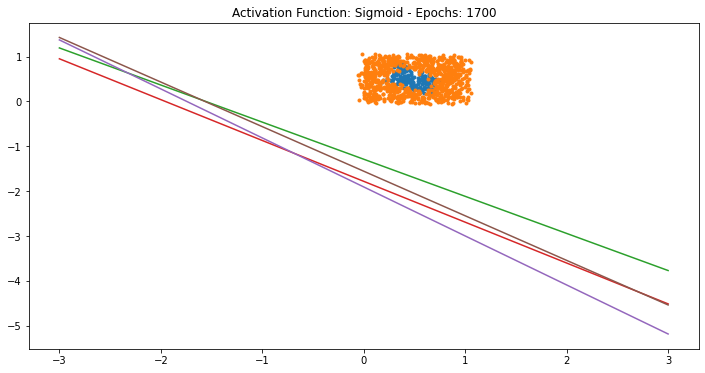

Epoch: 1800
G1-Weight: tensor([[2.4824, 2.9911]]) G1-Bias: tensor([3.9083])
G2-Weight: tensor([[2.1007, 2.3041]]) G2-Bias: tensor([4.1344])
G3-Weight: tensor([[2.3985, 2.2039]]) G1-Bias: tensor([4.2226])
G4-Weight: tensor([[2.6417, 2.6608]]) G2-Bias: tensor([4.1778])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.4824 * x + 3.9083) / 2.9911)
z2: y = -((2.1007 * x + 4.1344) / 2.3041)
z3: y = -((2.3985 * x + 4.2226) / 2.2039)
z4: y = -((2.6417 * x + 4.1778) / 2.6608)


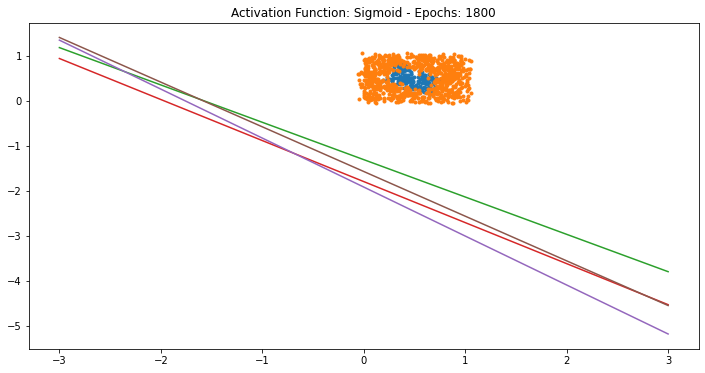

Epoch: 1900
G1-Weight: tensor([[2.5126, 3.0172]]) G1-Bias: tensor([3.9909])
G2-Weight: tensor([[2.1297, 2.3330]]) G2-Bias: tensor([4.2128])
G3-Weight: tensor([[2.4242, 2.2352]]) G1-Bias: tensor([4.3011])
G4-Weight: tensor([[2.6689, 2.6905]]) G2-Bias: tensor([4.2585])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.5126 * x + 3.9909) / 3.0172)
z2: y = -((2.1297 * x + 4.2128) / 2.333)
z3: y = -((2.4242 * x + 4.3011) / 2.2352)
z4: y = -((2.6689 * x + 4.2585) / 2.6905)


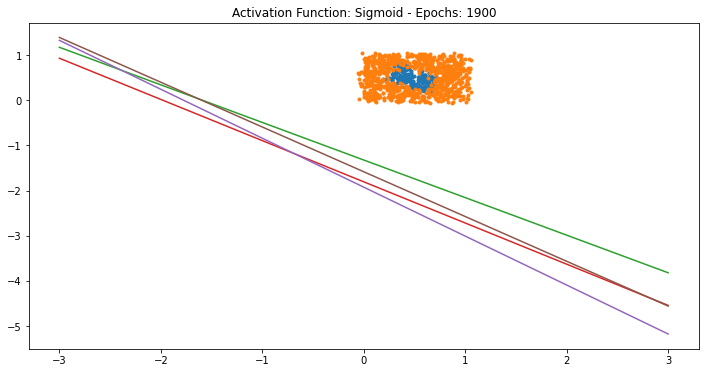

Epoch: 2000
G1-Weight: tensor([[2.5416, 3.0424]]) G1-Bias: tensor([4.0709])
G2-Weight: tensor([[2.1575, 2.3608]]) G2-Bias: tensor([4.2888])
G3-Weight: tensor([[2.4489, 2.2653]]) G1-Bias: tensor([4.3773])
G4-Weight: tensor([[2.6952, 2.7190]]) G2-Bias: tensor([4.3366])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.5416 * x + 4.0709) / 3.0424)
z2: y = -((2.1575 * x + 4.2888) / 2.3608)
z3: y = -((2.4489 * x + 4.3773) / 2.2653)
z4: y = -((2.6952 * x + 4.3366) / 2.719)


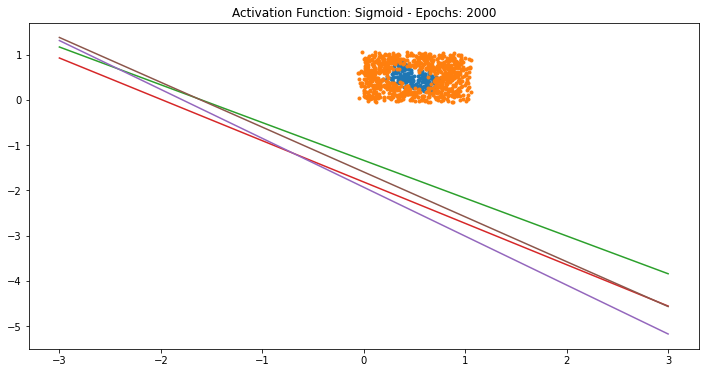

Epoch: 2100
G1-Weight: tensor([[2.5695, 3.0668]]) G1-Bias: tensor([4.1484])
G2-Weight: tensor([[2.1842, 2.3876]]) G2-Bias: tensor([4.3627])
G3-Weight: tensor([[2.4729, 2.2942]]) G1-Bias: tensor([4.4513])
G4-Weight: tensor([[2.7206, 2.7466]]) G2-Bias: tensor([4.4125])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.5695 * x + 4.1484) / 3.0668)
z2: y = -((2.1842 * x + 4.3627) / 2.3876)
z3: y = -((2.4729 * x + 4.4513) / 2.2942)
z4: y = -((2.7206 * x + 4.4125) / 2.7466)


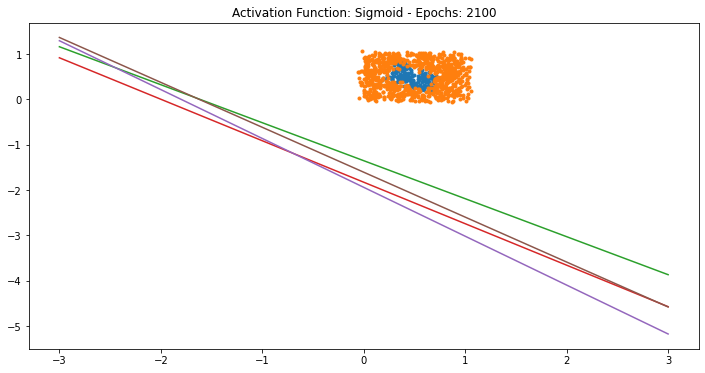

Epoch: 2200
G1-Weight: tensor([[2.5964, 3.0904]]) G1-Bias: tensor([4.2236])
G2-Weight: tensor([[2.2101, 2.4134]]) G2-Bias: tensor([4.4345])
G3-Weight: tensor([[2.4961, 2.3222]]) G1-Bias: tensor([4.5233])
G4-Weight: tensor([[2.7451, 2.7732]]) G2-Bias: tensor([4.4862])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.5964 * x + 4.2236) / 3.0904)
z2: y = -((2.2101 * x + 4.4345) / 2.4134)
z3: y = -((2.4961 * x + 4.5233) / 2.3222)
z4: y = -((2.7451 * x + 4.4862) / 2.7732)


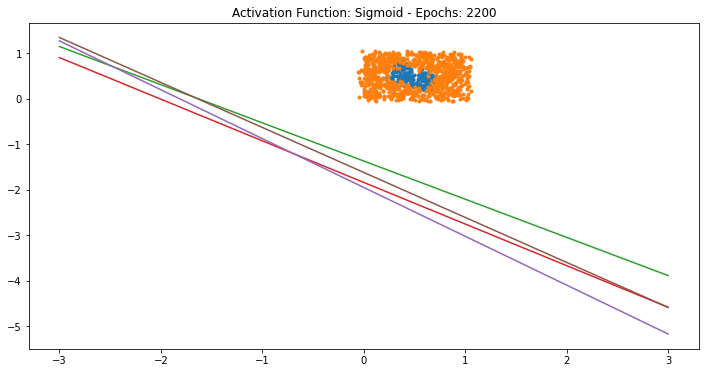

Epoch: 2300
G1-Weight: tensor([[2.6225, 3.1133]]) G1-Bias: tensor([4.2968])
G2-Weight: tensor([[2.2351, 2.4385]]) G2-Bias: tensor([4.5046])
G3-Weight: tensor([[2.5186, 2.3493]]) G1-Bias: tensor([4.5935])
G4-Weight: tensor([[2.7690, 2.7990]]) G2-Bias: tensor([4.5580])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.6225 * x + 4.2968) / 3.1133)
z2: y = -((2.2351 * x + 4.5046) / 2.4385)
z3: y = -((2.5186 * x + 4.5935) / 2.3493)
z4: y = -((2.769 * x + 4.558) / 2.799)


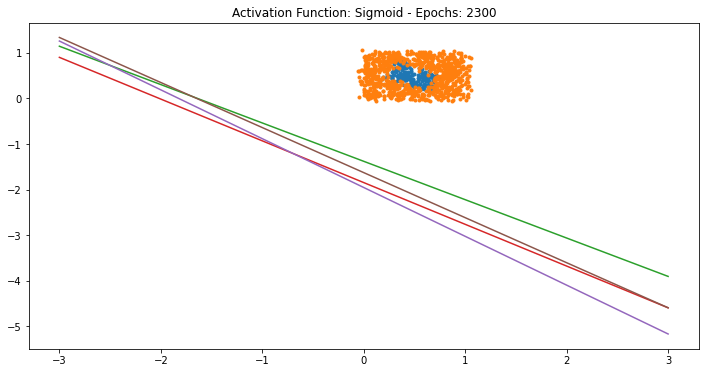

Epoch: 2400
G1-Weight: tensor([[2.6478, 3.1356]]) G1-Bias: tensor([4.3682])
G2-Weight: tensor([[2.2594, 2.4628]]) G2-Bias: tensor([4.5730])
G3-Weight: tensor([[2.5404, 2.3755]]) G1-Bias: tensor([4.6621])
G4-Weight: tensor([[2.7921, 2.8241]]) G2-Bias: tensor([4.6280])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.6478 * x + 4.3682) / 3.1356)
z2: y = -((2.2594 * x + 4.573) / 2.4628)
z3: y = -((2.5404 * x + 4.6621) / 2.3755)
z4: y = -((2.7921 * x + 4.628) / 2.8241)


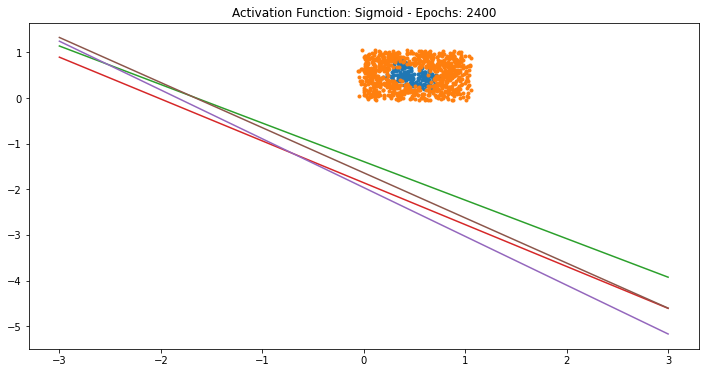

Epoch: 2500
G1-Weight: tensor([[2.6723, 3.1573]]) G1-Bias: tensor([4.4378])
G2-Weight: tensor([[2.2830, 2.4864]]) G2-Bias: tensor([4.6400])
G3-Weight: tensor([[2.5617, 2.4010]]) G1-Bias: tensor([4.7292])
G4-Weight: tensor([[2.8147, 2.8485]]) G2-Bias: tensor([4.6964])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.6723 * x + 4.4378) / 3.1573)
z2: y = -((2.283 * x + 4.64) / 2.4864)
z3: y = -((2.5617 * x + 4.7292) / 2.401)
z4: y = -((2.8147 * x + 4.6964) / 2.8485)


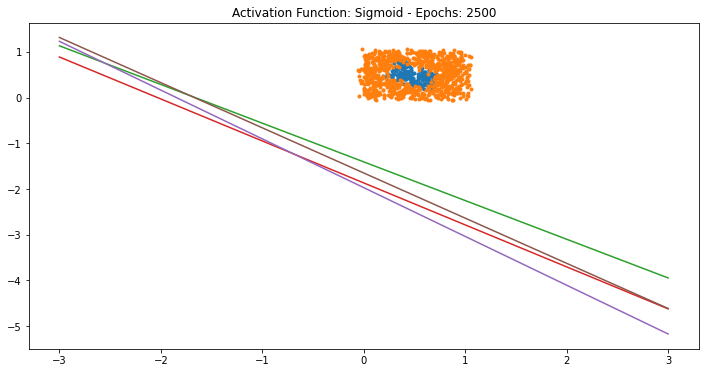

Epoch: 2600
G1-Weight: tensor([[2.6962, 3.1784]]) G1-Bias: tensor([4.5059])
G2-Weight: tensor([[2.3059, 2.5094]]) G2-Bias: tensor([4.7055])
G3-Weight: tensor([[2.5825, 2.4257]]) G1-Bias: tensor([4.7948])
G4-Weight: tensor([[2.8368, 2.8722]]) G2-Bias: tensor([4.7634])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.6962 * x + 4.5059) / 3.1784)
z2: y = -((2.3059 * x + 4.7055) / 2.5094)
z3: y = -((2.5825 * x + 4.7948) / 2.4257)
z4: y = -((2.8368 * x + 4.7634) / 2.8722)


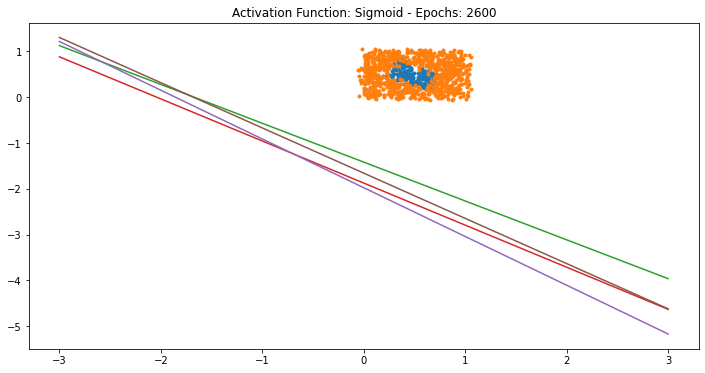

Epoch: 2700
G1-Weight: tensor([[2.7195, 3.1991]]) G1-Bias: tensor([4.5725])
G2-Weight: tensor([[2.3283, 2.5319]]) G2-Bias: tensor([4.7697])
G3-Weight: tensor([[2.6029, 2.4499]]) G1-Bias: tensor([4.8592])
G4-Weight: tensor([[2.8583, 2.8954]]) G2-Bias: tensor([4.8290])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.7195 * x + 4.5725) / 3.1991)
z2: y = -((2.3283 * x + 4.7697) / 2.5319)
z3: y = -((2.6029 * x + 4.8592) / 2.4499)
z4: y = -((2.8583 * x + 4.829) / 2.8954)


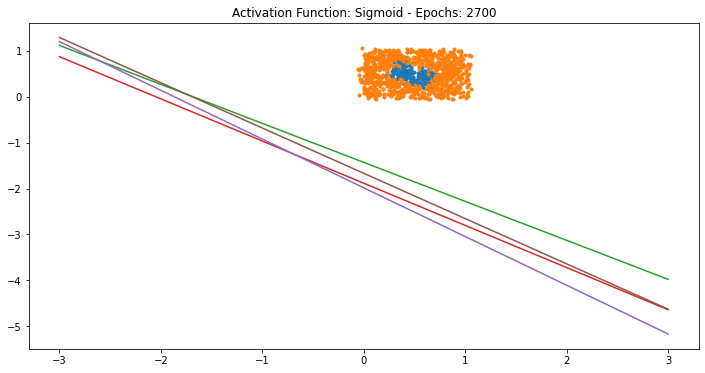

Epoch: 2800
G1-Weight: tensor([[2.7422, 3.2193]]) G1-Bias: tensor([4.6379])
G2-Weight: tensor([[2.3501, 2.5538]]) G2-Bias: tensor([4.8328])
G3-Weight: tensor([[2.6227, 2.4734]]) G1-Bias: tensor([4.9224])
G4-Weight: tensor([[2.8793, 2.9180]]) G2-Bias: tensor([4.8933])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.7422 * x + 4.6379) / 3.2193)
z2: y = -((2.3501 * x + 4.8328) / 2.5538)
z3: y = -((2.6227 * x + 4.9224) / 2.4734)
z4: y = -((2.8793 * x + 4.8933) / 2.918)


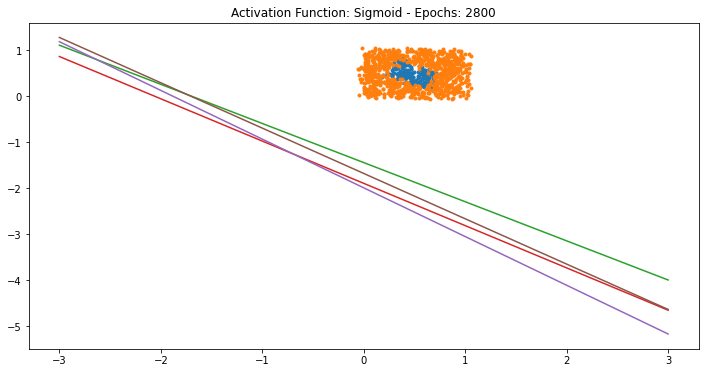

Epoch: 2900
G1-Weight: tensor([[2.7644, 3.2391]]) G1-Bias: tensor([4.7020])
G2-Weight: tensor([[2.3715, 2.5752]]) G2-Bias: tensor([4.8948])
G3-Weight: tensor([[2.6422, 2.4964]]) G1-Bias: tensor([4.9844])
G4-Weight: tensor([[2.8999, 2.9402]]) G2-Bias: tensor([4.9565])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.7644 * x + 4.702) / 3.2391)
z2: y = -((2.3715 * x + 4.8948) / 2.5752)
z3: y = -((2.6422 * x + 4.9844) / 2.4964)
z4: y = -((2.8999 * x + 4.9565) / 2.9402)


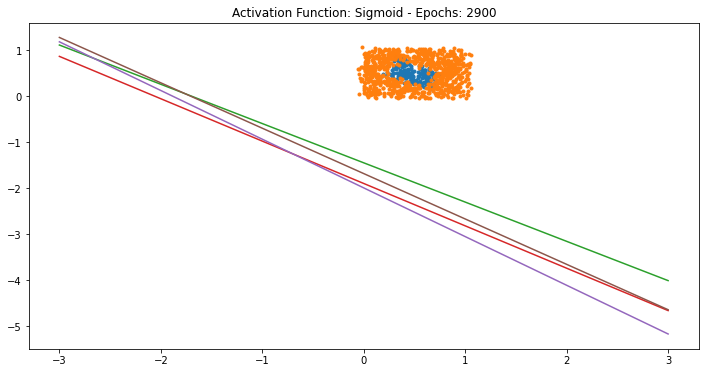

Epoch: 3000
G1-Weight: tensor([[2.7861, 3.2585]]) G1-Bias: tensor([4.7649])
G2-Weight: tensor([[2.3924, 2.5962]]) G2-Bias: tensor([4.9557])
G3-Weight: tensor([[2.6613, 2.5189]]) G1-Bias: tensor([5.0455])
G4-Weight: tensor([[2.9201, 2.9619]]) G2-Bias: tensor([5.0186])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.7861 * x + 4.7649) / 3.2585)
z2: y = -((2.3924 * x + 4.9557) / 2.5962)
z3: y = -((2.6613 * x + 5.0455) / 2.5189)
z4: y = -((2.9201 * x + 5.0186) / 2.9619)


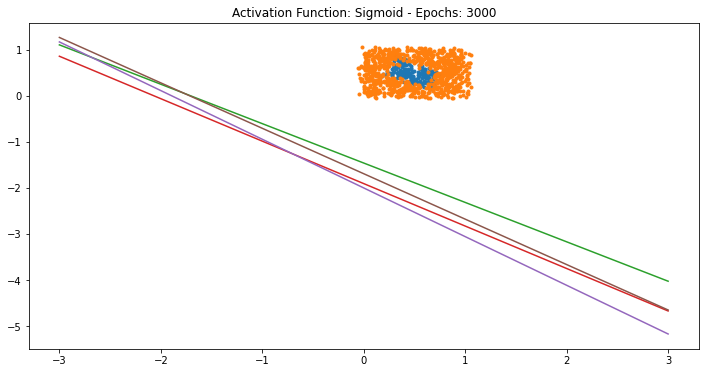

Epoch: 3100
G1-Weight: tensor([[2.8074, 3.2776]]) G1-Bias: tensor([4.8269])
G2-Weight: tensor([[2.4129, 2.6168]]) G2-Bias: tensor([5.0158])
G3-Weight: tensor([[2.6801, 2.5409]]) G1-Bias: tensor([5.1056])
G4-Weight: tensor([[2.9400, 2.9831]]) G2-Bias: tensor([5.0796])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.8074 * x + 4.8269) / 3.2776)
z2: y = -((2.4129 * x + 5.0158) / 2.6168)
z3: y = -((2.6801 * x + 5.1056) / 2.5409)
z4: y = -((2.94 * x + 5.0796) / 2.9831)


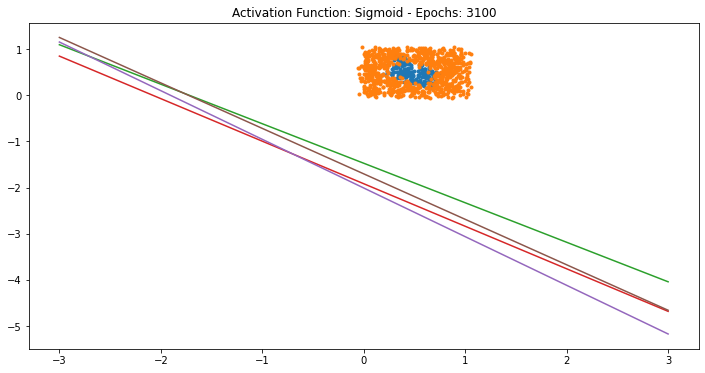

Epoch: 3200
G1-Weight: tensor([[2.8283, 3.2963]]) G1-Bias: tensor([4.8878])
G2-Weight: tensor([[2.4330, 2.6370]]) G2-Bias: tensor([5.0749])
G3-Weight: tensor([[2.6985, 2.5625]]) G1-Bias: tensor([5.1649])
G4-Weight: tensor([[2.9595, 3.0040]]) G2-Bias: tensor([5.1398])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.8283 * x + 4.8878) / 3.2963)
z2: y = -((2.433 * x + 5.0749) / 2.637)
z3: y = -((2.6985 * x + 5.1649) / 2.5625)
z4: y = -((2.9595 * x + 5.1398) / 3.004)


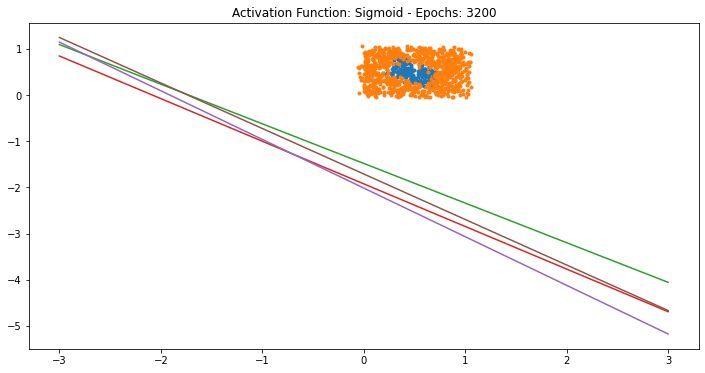

Epoch: 3300
G1-Weight: tensor([[2.8488, 3.3147]]) G1-Bias: tensor([4.9479])
G2-Weight: tensor([[2.4527, 2.6568]]) G2-Bias: tensor([5.1332])
G3-Weight: tensor([[2.7167, 2.5837]]) G1-Bias: tensor([5.2233])
G4-Weight: tensor([[2.9787, 3.0245]]) G2-Bias: tensor([5.1991])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.8488 * x + 4.9479) / 3.3147)
z2: y = -((2.4527 * x + 5.1332) / 2.6568)
z3: y = -((2.7167 * x + 5.2233) / 2.5837)
z4: y = -((2.9787 * x + 5.1991) / 3.0245)


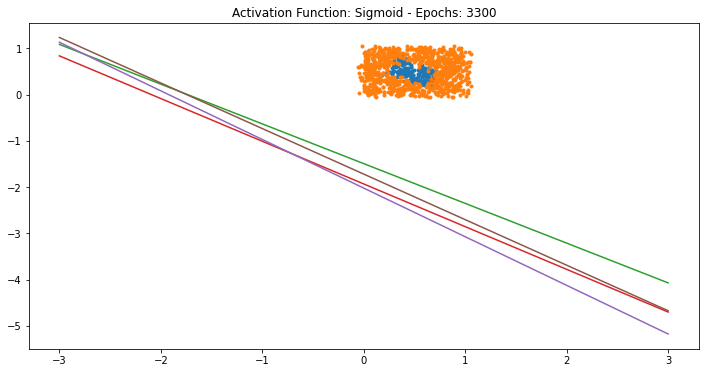

Epoch: 3400
G1-Weight: tensor([[2.8689, 3.3329]]) G1-Bias: tensor([5.0071])
G2-Weight: tensor([[2.4721, 2.6763]]) G2-Bias: tensor([5.1908])
G3-Weight: tensor([[2.7345, 2.6045]]) G1-Bias: tensor([5.2810])
G4-Weight: tensor([[2.9975, 3.0447]]) G2-Bias: tensor([5.2576])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.8689 * x + 5.0071) / 3.3329)
z2: y = -((2.4721 * x + 5.1908) / 2.6763)
z3: y = -((2.7345 * x + 5.281) / 2.6045)
z4: y = -((2.9975 * x + 5.2576) / 3.0447)


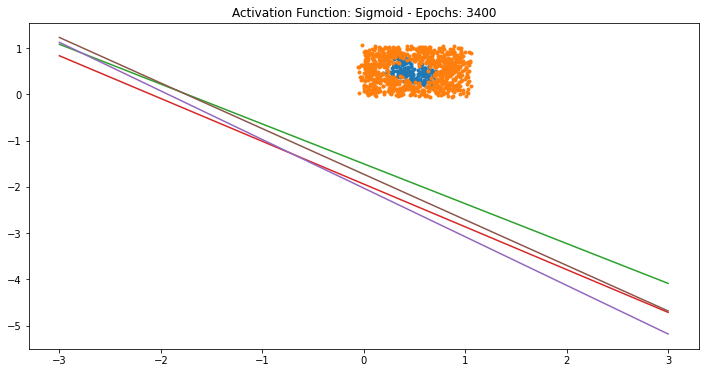

Epoch: 3500
G1-Weight: tensor([[2.8887, 3.3508]]) G1-Bias: tensor([5.0655])
G2-Weight: tensor([[2.4911, 2.6954]]) G2-Bias: tensor([5.2477])
G3-Weight: tensor([[2.7521, 2.6250]]) G1-Bias: tensor([5.3379])
G4-Weight: tensor([[3.0161, 3.0645]]) G2-Bias: tensor([5.3154])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.8887 * x + 5.0655) / 3.3508)
z2: y = -((2.4911 * x + 5.2477) / 2.6954)
z3: y = -((2.7521 * x + 5.3379) / 2.625)
z4: y = -((3.0161 * x + 5.3154) / 3.0645)


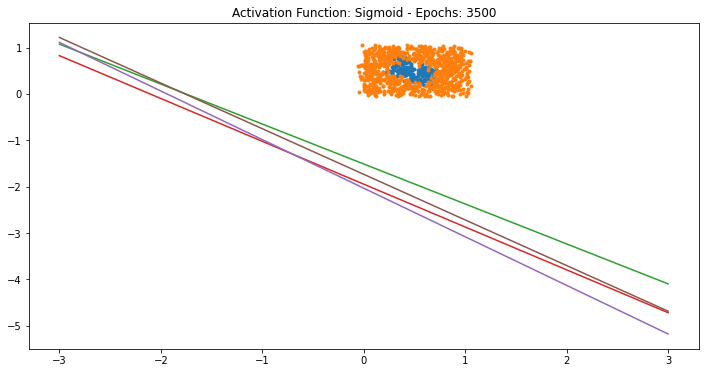

Epoch: 3600
G1-Weight: tensor([[2.9082, 3.3684]]) G1-Bias: tensor([5.1231])
G2-Weight: tensor([[2.5099, 2.7143]]) G2-Bias: tensor([5.3039])
G3-Weight: tensor([[2.7695, 2.6451]]) G1-Bias: tensor([5.3942])
G4-Weight: tensor([[3.0345, 3.0841]]) G2-Bias: tensor([5.3724])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.9082 * x + 5.1231) / 3.3684)
z2: y = -((2.5099 * x + 5.3039) / 2.7143)
z3: y = -((2.7695 * x + 5.3942) / 2.6451)
z4: y = -((3.0345 * x + 5.3724) / 3.0841)


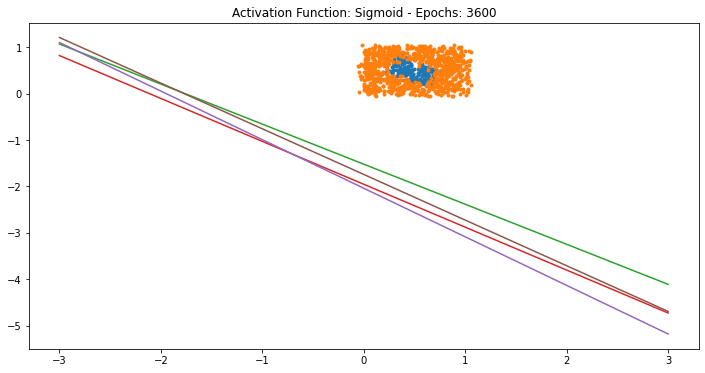

Epoch: 3700
G1-Weight: tensor([[2.9274, 3.3858]]) G1-Bias: tensor([5.1801])
G2-Weight: tensor([[2.5284, 2.7329]]) G2-Bias: tensor([5.3595])
G3-Weight: tensor([[2.7866, 2.6649]]) G1-Bias: tensor([5.4499])
G4-Weight: tensor([[3.0526, 3.1033]]) G2-Bias: tensor([5.4288])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.9274 * x + 5.1801) / 3.3858)
z2: y = -((2.5284 * x + 5.3595) / 2.7329)
z3: y = -((2.7866 * x + 5.4499) / 2.6649)
z4: y = -((3.0526 * x + 5.4288) / 3.1033)


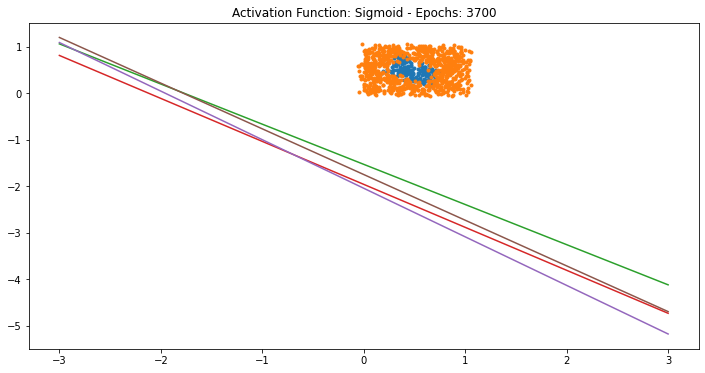

Epoch: 3800
G1-Weight: tensor([[2.9464, 3.4030]]) G1-Bias: tensor([5.2365])
G2-Weight: tensor([[2.5467, 2.7513]]) G2-Bias: tensor([5.4145])
G3-Weight: tensor([[2.8035, 2.6844]]) G1-Bias: tensor([5.5049])
G4-Weight: tensor([[3.0705, 3.1223]]) G2-Bias: tensor([5.4846])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.9464 * x + 5.2365) / 3.403)
z2: y = -((2.5467 * x + 5.4145) / 2.7513)
z3: y = -((2.8035 * x + 5.5049) / 2.6844)
z4: y = -((3.0705 * x + 5.4846) / 3.1223)


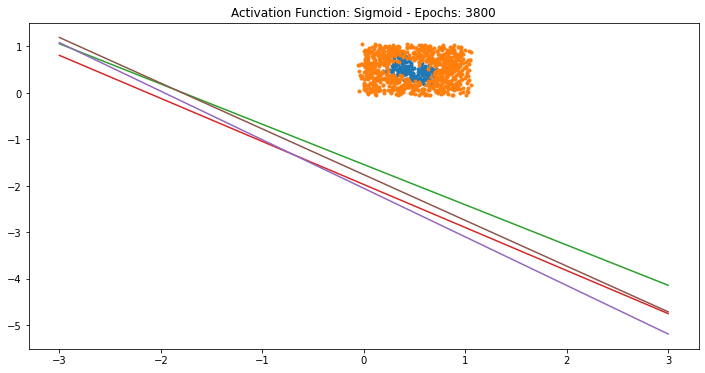

Epoch: 3900
G1-Weight: tensor([[2.9651, 3.4200]]) G1-Bias: tensor([5.2922])
G2-Weight: tensor([[2.5647, 2.7694]]) G2-Bias: tensor([5.4690])
G3-Weight: tensor([[2.8202, 2.7037]]) G1-Bias: tensor([5.5595])
G4-Weight: tensor([[3.0881, 3.1411]]) G2-Bias: tensor([5.5398])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.9651 * x + 5.2922) / 3.42)
z2: y = -((2.5647 * x + 5.469) / 2.7694)
z3: y = -((2.8202 * x + 5.5595) / 2.7037)
z4: y = -((3.0881 * x + 5.5398) / 3.1411)


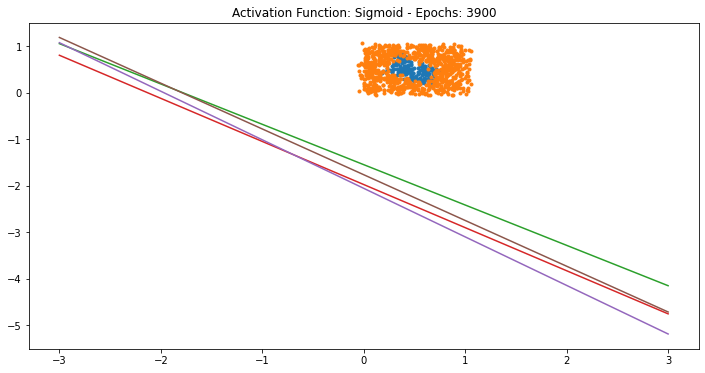

Epoch: 4000
G1-Weight: tensor([[2.9835, 3.4368]]) G1-Bias: tensor([5.3474])
G2-Weight: tensor([[2.5824, 2.7872]]) G2-Bias: tensor([5.5229])
G3-Weight: tensor([[2.8368, 2.7227]]) G1-Bias: tensor([5.6135])
G4-Weight: tensor([[3.1056, 3.1596]]) G2-Bias: tensor([5.5944])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((2.9835 * x + 5.3474) / 3.4368)
z2: y = -((2.5824 * x + 5.5229) / 2.7872)
z3: y = -((2.8368 * x + 5.6135) / 2.7227)
z4: y = -((3.1056 * x + 5.5944) / 3.1596)


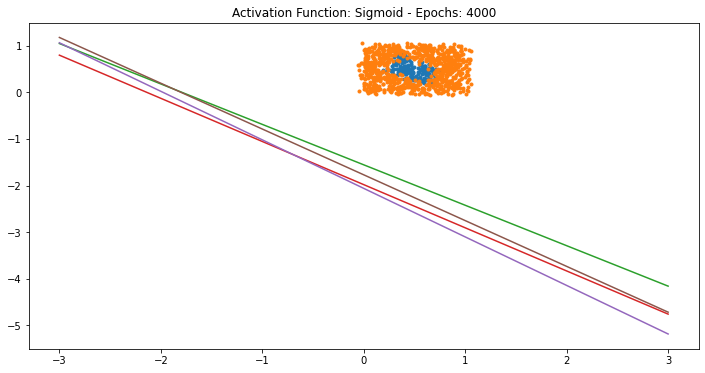

In [8]:
network = Net4(activation='sigmoid')

optimizer = optim.Adam(network.parameters(), lr=0.0233)
criterion = nn.MSELoss()

x = torch.linspace(-3, 3)

beta_g1_arr = []
beta_g2_arr = []
beta_g3_arr = []
beta_g4_arr = []

beta_and_arr = []
loss_arr = []
running_loss = 0

for epoch in range(4001):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights

    #beta_g1_arr.append(beta_g1)
    #beta_g2_arr.append(beta_g2)
    #beta_g3_arr.append(beta_g3)
    #beta_g4_arr.append(beta_g4)

    #beta_and_arr.append(beta_and)
    loss_arr.append(loss.item())
    running_loss += loss.item()

    if epoch %100 == 0:
        print("Epoch:", epoch)
        print("G1-Weight:", network.g1_layer.weight.data, "G1-Bias:", network.g1_layer.bias.data)
        print("G2-Weight:", network.g2_layer.weight.data, "G2-Bias:", network.g2_layer.bias.data)
        print("G3-Weight:", network.g3_layer.weight.data, "G1-Bias:", network.g3_layer.bias.data)
        print("G4-Weight:", network.g4_layer.weight.data, "G2-Bias:", network.g4_layer.bias.data)

        #print("AND-Weight G1G2:", network.undg1g2.weight.data, "AND-Bias:", network.undg1g2.bias.data)
        #print("AND-Weight G3G4:", network.undg3g4.weight.data, "AND-Bias:", network.undg3g4.bias.data)
        print("AND-Weight GOut:", network.undgout.weight.data, "AND-Bias:", network.undgout.bias.data)

        y1 = -((network.g1_layer.weight.squeeze()[0] * x + network.g1_layer.bias[0]) / network.g1_layer.weight.squeeze()[1])
        y2 = -((network.g2_layer.weight.squeeze()[0] * x + network.g2_layer.bias[0]) / network.g2_layer.weight.squeeze()[1])
        y3 = -((network.g3_layer.weight.squeeze()[0] * x + network.g3_layer.bias[0]) / network.g3_layer.weight.squeeze()[1])
        y4 = -((network.g4_layer.weight.squeeze()[0] * x + network.g4_layer.bias[0]) / network.g4_layer.weight.squeeze()[1])
        print(f'z1: y = -(({round(float(network.g1_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g1_layer.bias[0]),4)}) / {round(float(network.g1_layer.weight.squeeze()[1]), 4)})')
        print(f'z2: y = -(({round(float(network.g2_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g2_layer.bias[0]),4)}) / {round(float(network.g2_layer.weight.squeeze()[1]), 4)})')
        print(f'z3: y = -(({round(float(network.g3_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g3_layer.bias[0]),4)}) / {round(float(network.g3_layer.weight.squeeze()[1]), 4)})')
        print(f'z4: y = -(({round(float(network.g4_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g4_layer.bias[0]),4)}) / {round(float(network.g4_layer.weight.squeeze()[1]), 4)})')
        
        plt.figure(figsize=(12,6))
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #plt.title(f'Epoch: {epoch}; Learning Rate: 0.02\n β Linear Layer: {round(betagerade,4)} ; β AND Operator: {round(betaand,4)}')
        plt.title(f'Activation Function: Sigmoid - Epochs: {epoch}')
        #print("Beta:", betas)
        #print("Beta-Gerade:", betagerade)
        #print("Beta-AND:", betaand)
        #print("Loss:", running_loss/1000)
        #plt.ylim(0,1)
        #plt.xlim(0,1)
    plt.show()

<function matplotlib.pyplot.show>

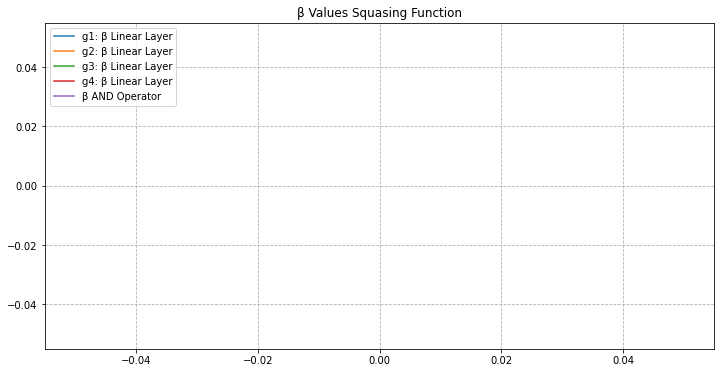

In [9]:
plt.figure(figsize=(12,6))
plt.plot(beta_g1_arr, label='g1: β Linear Layer')
plt.plot(beta_g2_arr, label='g2: β Linear Layer')
plt.plot(beta_g3_arr, label='g3: β Linear Layer')
plt.plot(beta_g4_arr, label='g4: β Linear Layer')

plt.plot(beta_and_arr, label='β AND Operator')
plt.legend(loc=2)
plt.grid(True, axis='both', linestyle='--')
plt.title('β Values Squasing Function')
plt.show

<function matplotlib.pyplot.show>

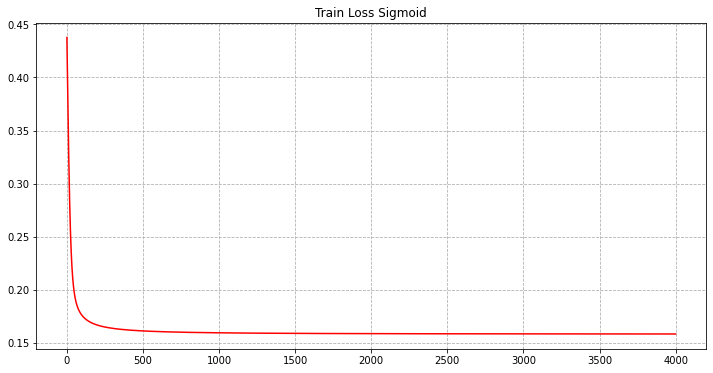

In [10]:
plt.figure(figsize=(12,6))
plt.title('Train Loss Sigmoid')
plt.plot(loss_arr, label='Loss', color='r')
plt.grid(True, axis='both', linestyle='--')
plt.show